In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [3]:
# Filtern nach Store
store_number = 2
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

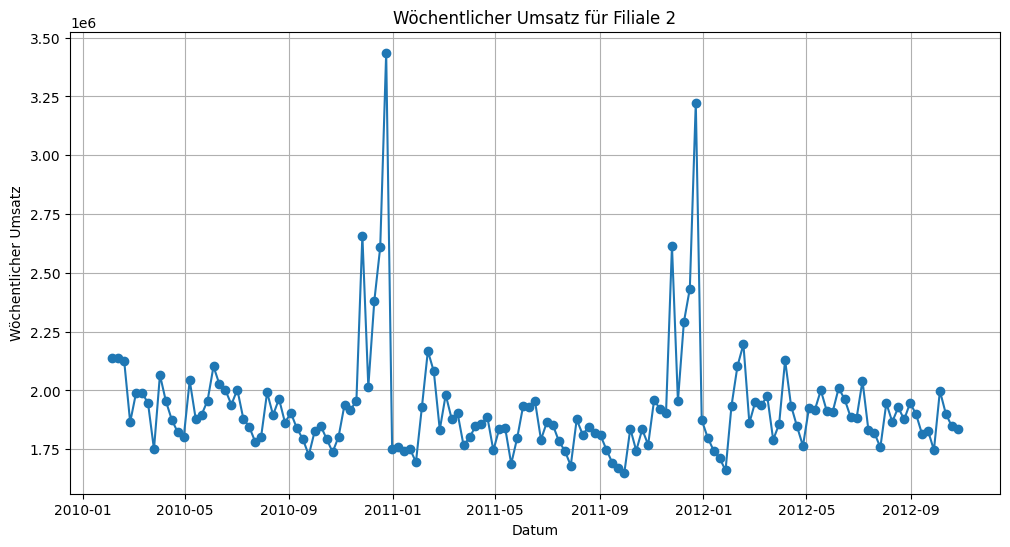

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Wöchentlicher Umsatz für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.grid(True)
plt.show()

Seasonal

In [5]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [6]:
model_type = 'SARIMA'
#model_type = 'Naive'
#model_type = 'Additive'

Residuen und Fitted Values berechnen

In [7]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'Additive':
    resid, fitted_values = build_naive_additive(sales, sample = 'IS')
    resid_oos, fitted_values_oos = build_naive_additive(sales, sample = 'OOS')

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_70_new.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model, y_train, y_test = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)


    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]


    forecast = sarima_model.get_forecast(steps=43)
    forecast = forecast.predicted_mean
    sarima_model.summary()


print(len(sales))
print(len(fitted_values))
print(len(forecast))

143
99
43


Plot

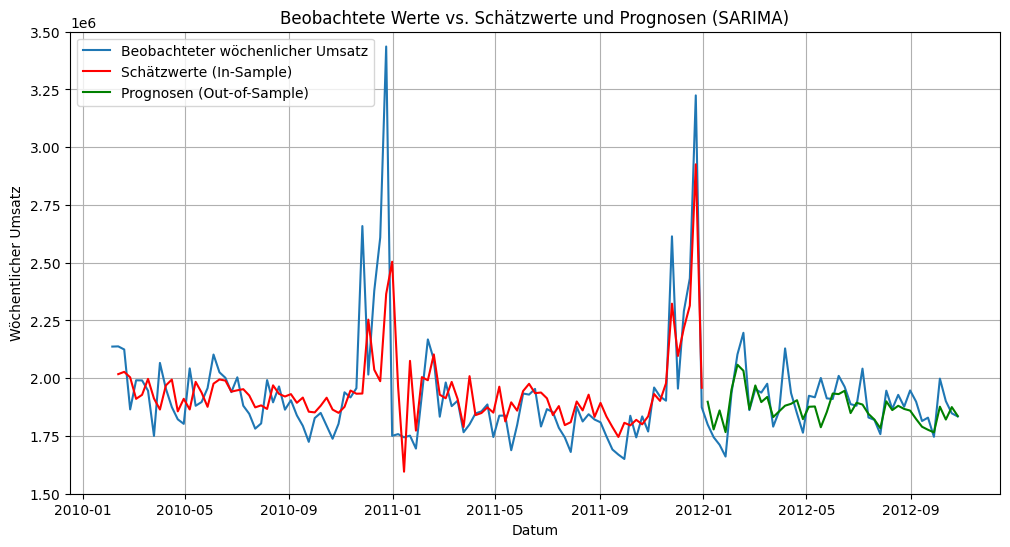

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Schätzwerte (In-Sample)')
plt.plot(forecast, color='green', label='Prognosen (Out-of-Sample)')
plt.title('Beobachtete Werte vs. Schätzwerte und Prognosen (SARIMA)')
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.ylim(1500000, 3500000)
plt.show()


In [9]:
pd.set_option('display.max_rows', None)
print(resid.count())
print(len(resid))

99
99


Korrelations Tests

Box Pierce Test: 0.2835
Ljung Box Test: 0.2089
Monti Test: 0.0407
Fisher Test: 0.5765
Fisher Test: 0.3699
Pena Rodriguez Test: 0.0098
Breusch Godfrey: 0.5959
Run Test: 0.6960
Durbin Watson: 2.0397


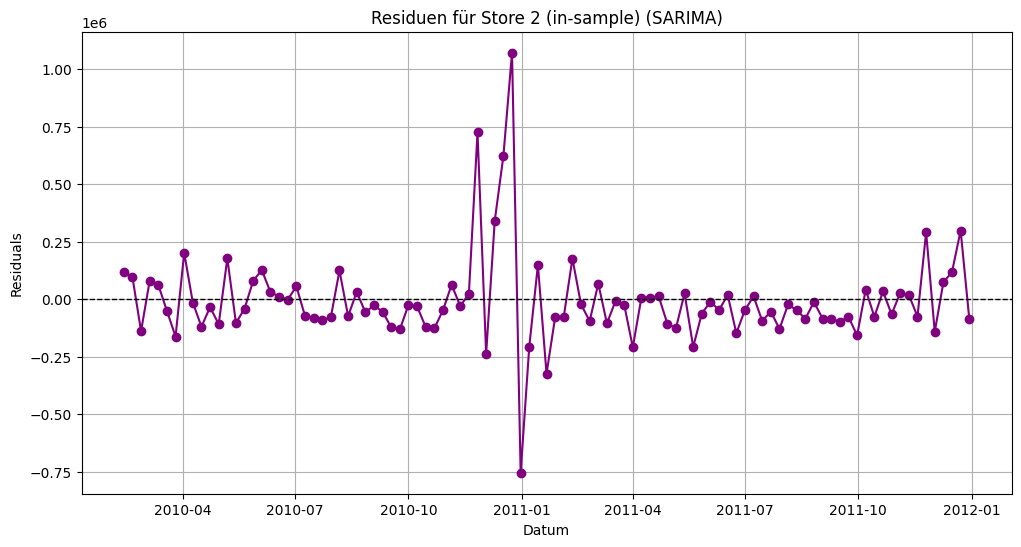

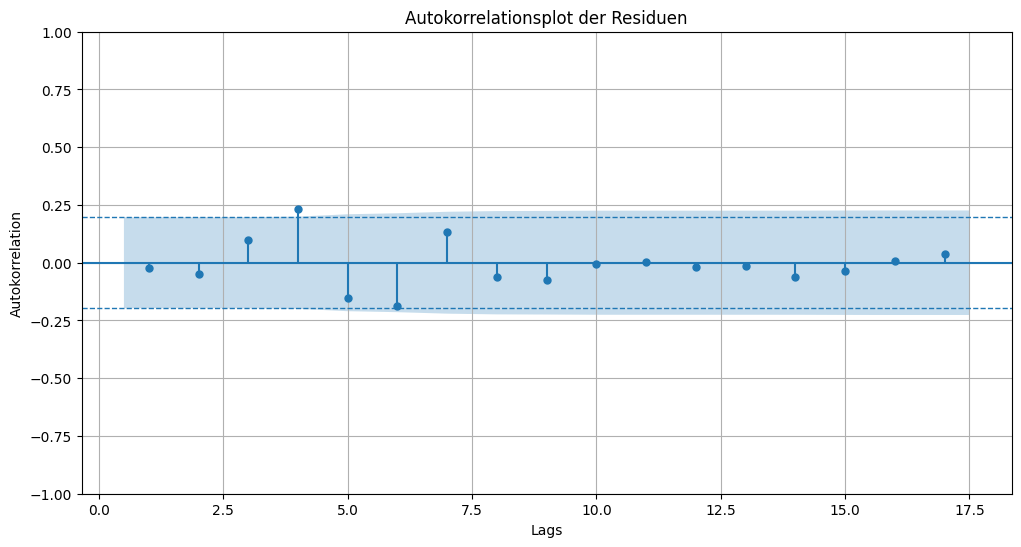

In [10]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 20)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 20)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 20)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 20)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 20)
pena_rodriguez_test_original(residuals = resid, store_num = store_number, model = model_type, m = 20)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 20)


run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 17, print_results = True)



Mittelwert Tests

In [11]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
vorzeichen_test(resid)
kolmogorov_test(resid)



Mittelwert der Residuen: -7900.4589
T-Test: 0.6929
Wilcoxon Test: 0.0139
Sign Test: 0.0086
Kolmogorov Test: 0.0006


(0.19910214839726603, 0.0006472577891553088)

SMAPE

In [12]:
# SMAPE berechnen
denom = (np.abs(y_train) + np.abs(fitted_values))
# Vermeide Division durch 0
mask = denom != 0
smape = 100 * np.mean(2 * np.abs(fitted_values[mask] - y_train[mask]) / denom[mask])
print(f"SMAPE: {smape:.2f}%")

SMAPE: 5.71%


Kreuz Validierung

In [13]:
#if model_type == 'SARIMA':
#    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
#if model_type == 'Naive':
#    cv_df = cross_validation_naive(sales)
#if model_type == 'Additive':
#    residuals, fitted_series = build_naive_additive(sales, sample = 'OOS')



Korrelations Tests

Box Pierce Test: 0.3236
Ljung Box Test: 0.2597
Monti Test: 0.1411
Fisher Test: 0.6154
Fisher Test: 0.4856
Pena Rodriguez (m=29, N=1000): 0.6943
Breusch–Godfrey (OOS): 0.8701
Run Test: 0.5138
Durbin Watson: 1.4504


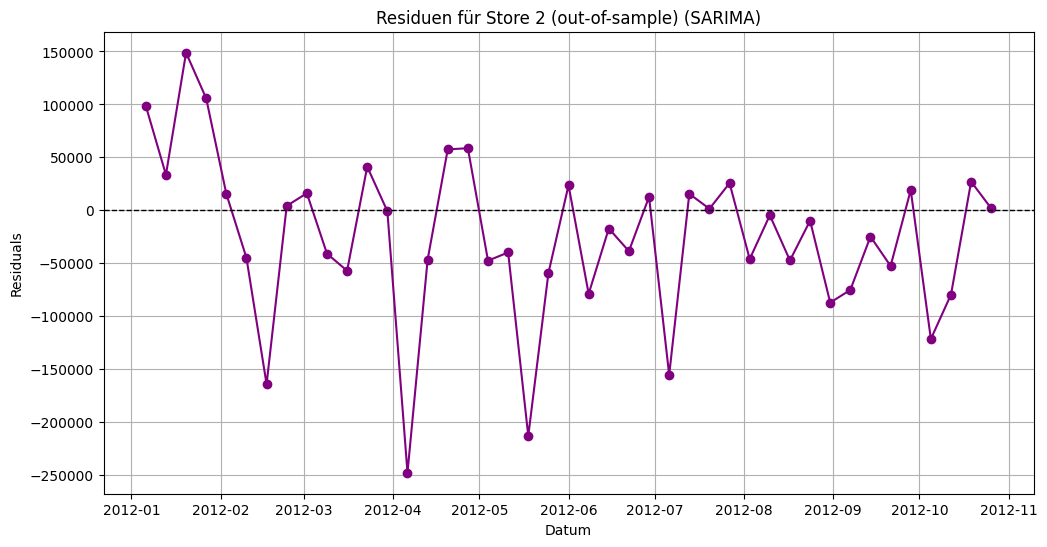

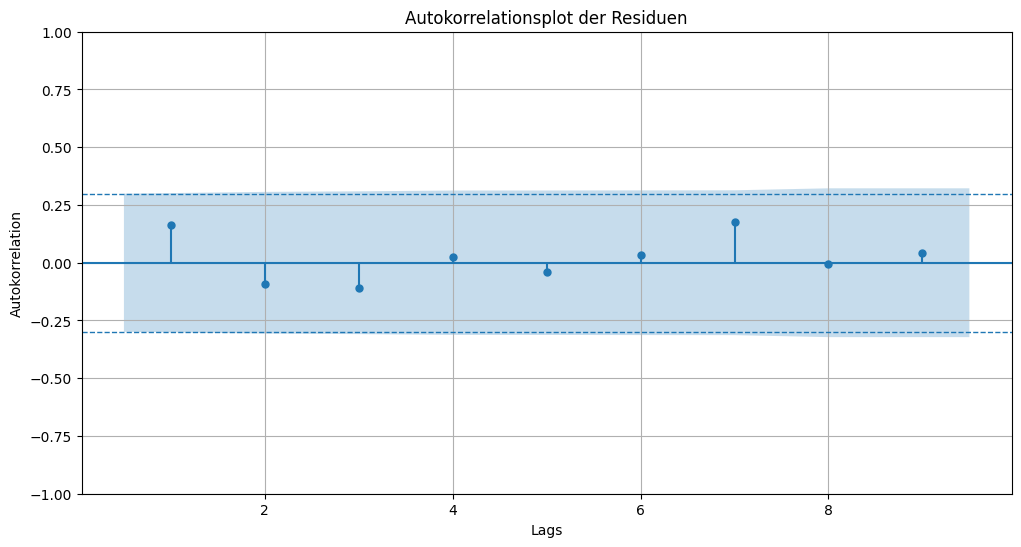

In [14]:
errors = forecast - y_test

#errors = cv_df['error']
#print(len(errors))


box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 9)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 9)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 9)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 9)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 9)
pena_rodriguez_test_mc(residuals = errors)


if model_type == 'SARIMA':
    breusch_godfrey_manuell(errors, lags = 9)
if model_type == 'Naive':
    breusch_godfrey_manuell(errors, lags = 9)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors, lags = 9, print_results = True)


Mittelwert Tests

In [15]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)



Mittelwert der Errors: -25458.222887708773
T-Test: 0.0372
Wilcoxon Test: 0.0462
Binomial Test: 0.3604
Kolmogorov Test: 0.0538


(0.2007812610672074, 0.053804051635873096)

SMAPE

In [16]:
denom = (np.abs(y_test) + np.abs(forecast))
# Vermeide Division durch 0
mask = denom != 0
smape = 100 * np.mean(2 * np.abs(forecast[mask] - y_test[mask]) / denom[mask])


print(f"SMAPE: {smape:.2f}%")

SMAPE: 3.07%
